In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
import json
import imageio

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
import warnings
import pickle
warnings.filterwarnings("ignore")

from src.data_assemble.wrap_data import *
from src.models.WindCNN import *
from src.data_assemble.wrap_data import *

# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/
random.seed(24)

# наложить на карту
# экспоненциальное сглаживание пикселей

In [2]:
path_to_data = os.path.join('data', 'nn_data')
st_split_dict = train_val_test_split(path_to_data, train = 0.5, val = 0.25, test = 0.25, verbose = True)
path_to_dump = os.path.join('data','nn_data')
X, y = extract_splitted_data(path_to_dump, st_split_dict)

{'Train': ['Туапсе', 'Краснодар, Круглик'], 'Val': ['Анапа'], 'Test': ['Приморско-Ахтарск']}


In [3]:
batch_size = 1024
with open(os.path.join('conf', 'conv_config.json')) as fs:
    args = json.load(fs)

In [4]:
logger = TensorBoardLogger(save_dir='logs/wind', name='windnet')
trainer = pl.Trainer(max_epochs=50,
                    gpus='1',
                    benchmark=True,
                    check_val_every_n_epoch=1,
)


dm = WindDataModule(X=X, y=y, batch_size=batch_size, downsample=False)
model = WindNetPL(args)

# chk_path = "./lightning_logs/version_13/checkpoints/epoch=35-step=288.ckpt"
chk_path = "lightning_logs/version_0"
chk_path = os.path.join(chk_path, "checkpoints", os.listdir(os.path.join(chk_path, "checkpoints"))[0])
model2 = WindNetPL.load_from_checkpoint(chk_path, args=args)
model2.eval()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


WindNetPL(
  (net): WindNet(
    (conv1): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=800, out_features=2, bias=True)
    (net): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Flatten(start_dim=1, end_dim=-1)
      (6): Linear(in_features=800, out_features=2, bias=True)
      (7): Softmax(dim=None)
    )
  )
  (accuracy): Accuracy()
  (AUROC): AUROC()
  (precision_m): Precision()
  (recall): Recall()
  (F1): F1Score()
  (conf_matrix): ConfusionMatrix()
  (stats_scores): StatSco

In [5]:
tmp1 = torch.tensor(model2(dm.transform(dm.X_test))[:, 0] < 0.5, dtype=torch.float64).cpu().numpy()
tmp2 = dm.y_test[:].cpu().numpy()
# tmp3 = (tmp2 - tmp1).cpu().numpy()
# print(tmp3.sum())
# plt.plot((tmp2 - tmp1).cpu().numpy())
from sklearn.metrics import confusion_matrix
confusion_matrix(tmp2, tmp1)

array([[3629,    0],
       [  23,    0]])

In [6]:
model2(dm.transform(dm.X_test))[:, 1].max()

tensor(0.4916, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [7]:
model.conf_matrix(model2(dm.transform(dm.X_test))[:, 1], dm.y_test[:].long())

tensor([[3629,    0],
        [  23,    0]])

In [8]:
trainer.test(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_AUROC_step        0.5366712212562561
      test_acc_step         0.9937020540237427
      test_f1_step          0.7759081125259399
        test_loss           0.6913130107895981
   test_precision_step       0.993383526802063
    test_recall_step        0.6370021104812622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6913130107895981,
  'test_acc_step': 0.9937020540237427,
  'test_recall_step': 0.6370021104812622,
  'test_AUROC_step': 0.5366712212562561,
  'test_precision_step': 0.993383526802063,
  'test_f1_step': 0.7759081125259399}]

# PREPROCESSING 

In [9]:
path_to_data = os.path.join('data', 'nn_data_grid_inference')
grid_inference_ = {}
coincide_idx = -1
for i, curr_pix in tqdm(enumerate(os.listdir(path_to_data))):
# # st_split_dict = train_val_test_split(path_to_data, train = 0.5, val = 0.25, test = 0.25, verbose = True)
    X, y = extract_splitted_data(path_to_data, {'Grid': [curr_pix]})
    X_grid_t = torch.tensor(X["Grid"], device=model2.device).double()
    if torch.allclose(dm.X_test, X_grid_t):
        coincide_idx = i
    inference = model2(dm.transform(X_grid_t)).detach().cpu().numpy()
    grid_inference_[curr_pix] = inference
    if curr_pix == '(7, 4)':
        break
    # dm = WindDataModule(X=X, y=y, batch_size=batch_size, downsample=False)

70it [00:38,  1.84it/s]


In [10]:
grid_inference = {}
for k in grid_inference_.keys():
    try:
        k1, k2 = k[1:-1].split(', ')
        k1 = int(k1)
        
        k2 = int(k2)
        grid_inference[(k1, k2)] = grid_inference_[k]
    except AttributeError:
        pass
del grid_inference_

In [11]:
keys = list(grid_inference.keys())
sorted_tmp = sorted(keys, key=lambda x: x[0])
shift_x = sorted_tmp[0][0] + 1
max_x = sorted_tmp[-1][0] + shift_x
sorted_tmp = sorted(keys, key=lambda x: x[1])
shift_y = sorted_tmp[0][1] + 1
max_y = sorted_tmp[-1][1] + shift_y
some_key = keys[0]
grid = np.zeros((grid_inference[some_key].shape[0], max_x, max_y))

for k in grid_inference.keys():
    grid[:, k[0], k[1]] = grid_inference[k][:, 1]

In [12]:
grid.max()

0.5423009541397031

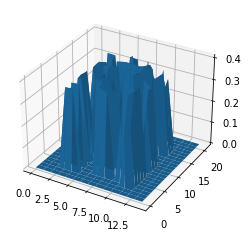

In [13]:
t = 900
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
x_range = np.arange(grid.shape[1])
y_range = np.arange(grid.shape[2])
data = grid[t, :, :]
X_mesh, Y_mesh = np.meshgrid(x_range, y_range)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X_mesh, Y_mesh, data.T)
# ha.set_zlim((0, 1))
plt.show()
# plt.savefig('tmp_dump/' + str(t) + '.png')

In [14]:
start_date = pd.to_datetime('2006-01-01')
str(start_date + pd.DateOffset(1) * 31)

'2006-02-01 00:00:00'

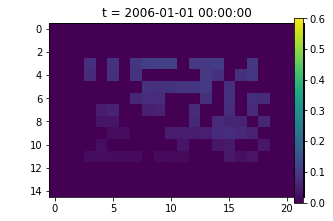

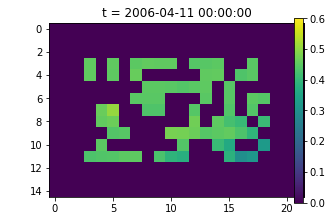

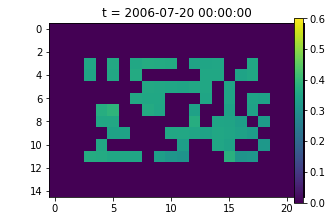

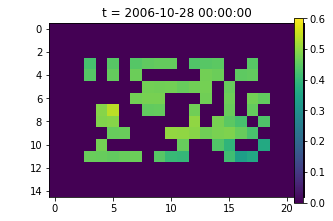

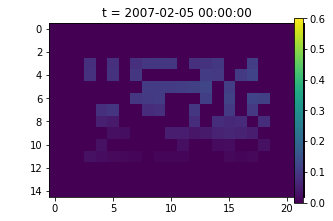

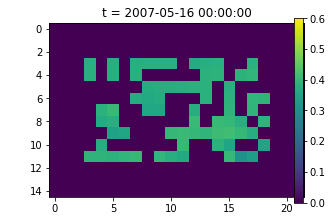

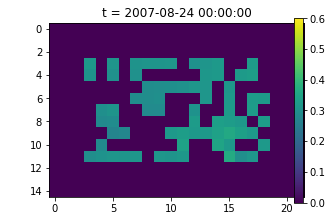

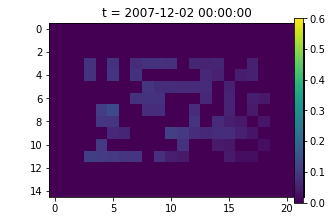

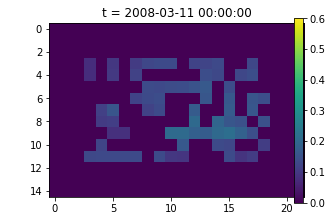

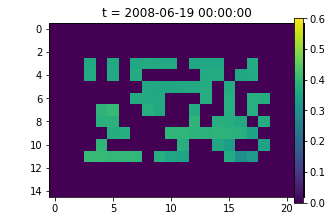

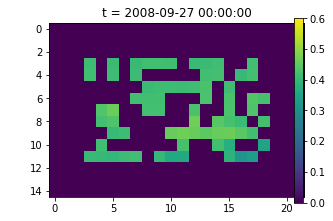

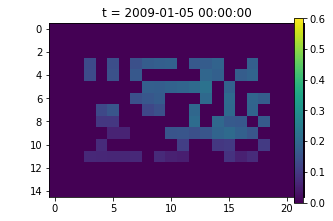

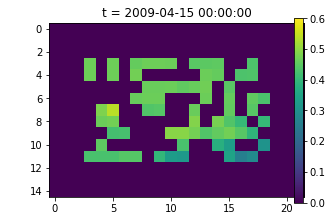

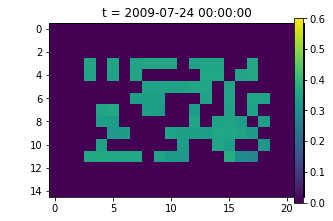

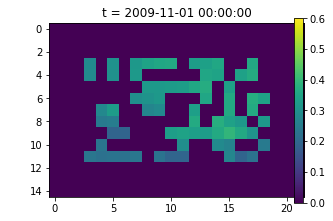

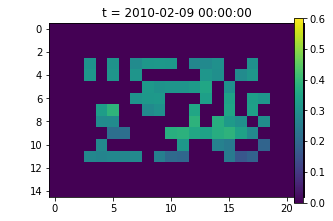

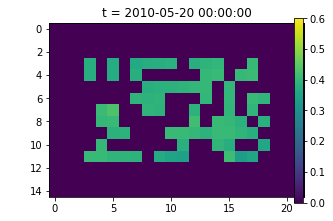

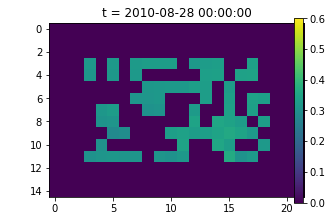

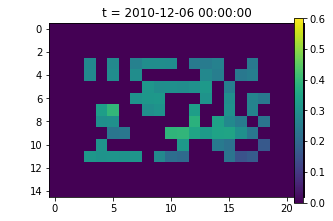

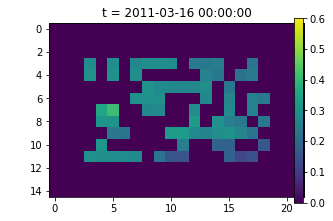

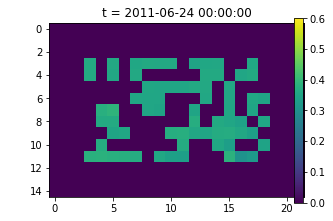

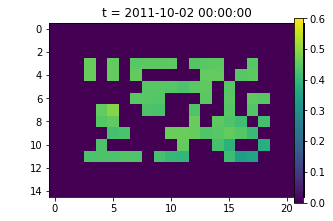

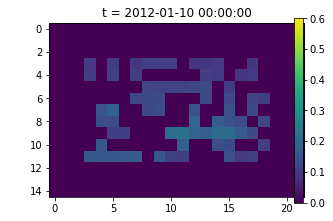

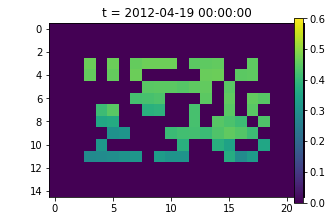

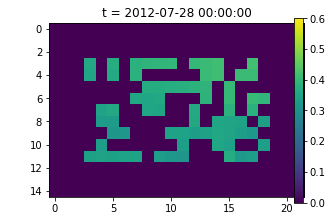

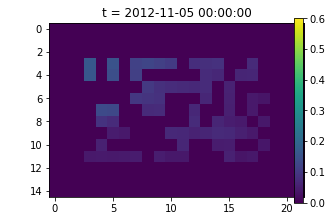

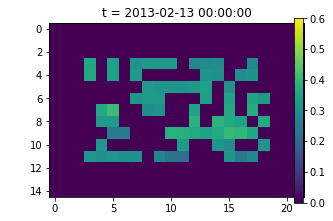

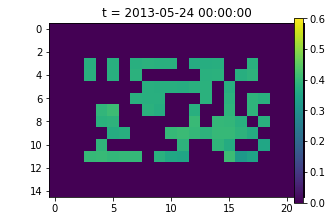

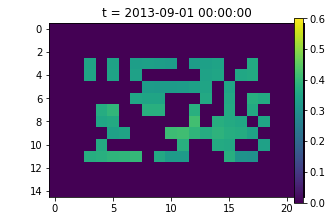

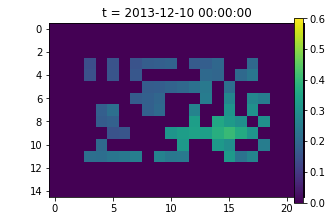

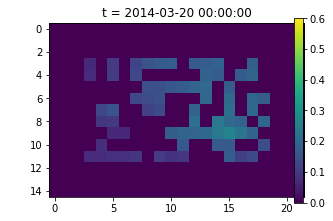

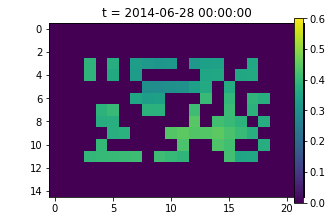

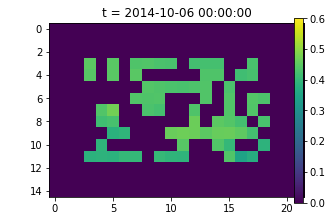

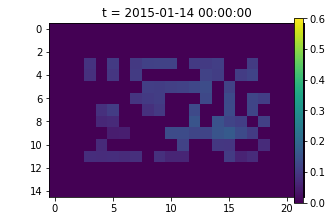

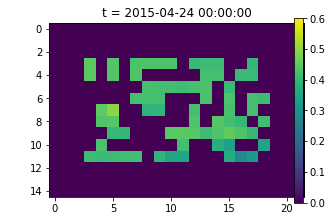

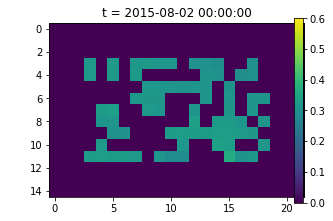

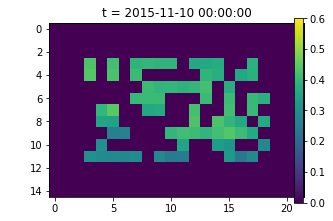

In [31]:
t = 300
for t in list(range(grid.shape[0]))[::100]:
    data = grid[t, :, :]
    fig = plt.figure(figsize=(6, 3.2))

    ax = fig.add_subplot(111)
    ax.set_title('t = ' + str(start_date + pd.DateOffset(1) * t))
    plt.imshow(data,vmin=0, vmax=0.6)
    # plt.colorbar()
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.savefig('tmp_dump_old/' + str(t) + '.png')
    # plt.show()

In [32]:
images = []
filenames = [os.path.join('tmp_dump_old', str(f) + '.png') for f in list(range(grid.shape[0]))[::100]]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('tmp_dump_old/wind_prob_maps_old.gif', images, duration=0.5)

# Наложение экспоненциального сглдаживания на карты

In [28]:
grid_new = np.zeros_like(grid)
for i in range(grid.shape[0]):
    grid_new[i,:,:] = ewma_vectorized_2d(data=grid[i,:,:], alpha=0.7, axis=1)
    grid_new[i,:,:] = ewma_vectorized_2d(data=grid_new[i,:,:], alpha=0.7, axis=0)

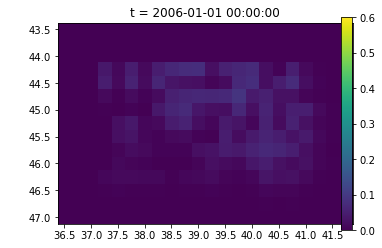

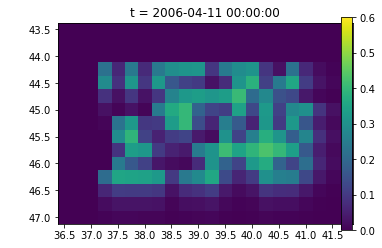

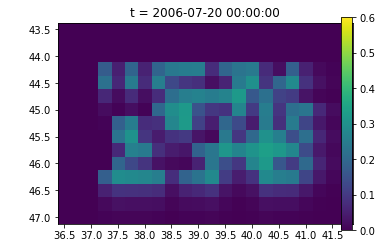

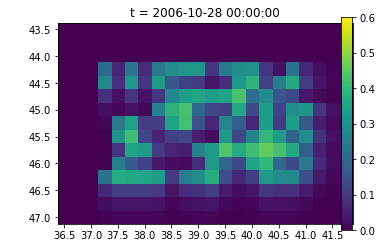

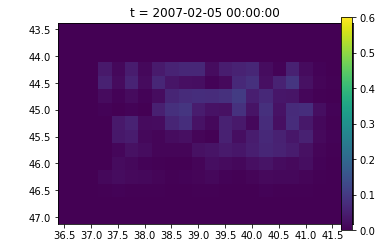

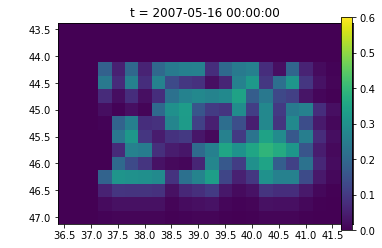

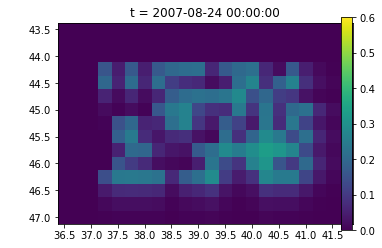

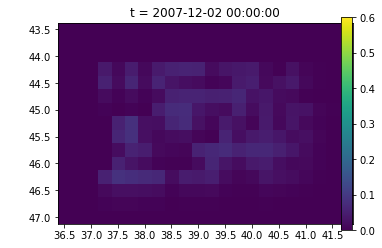

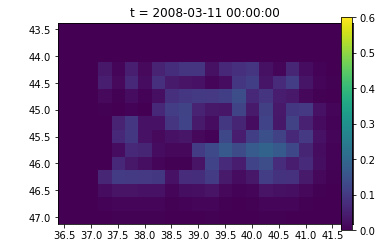

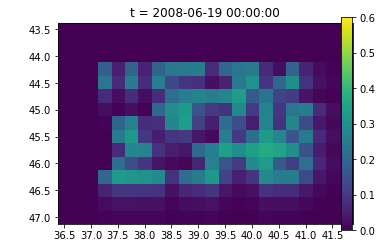

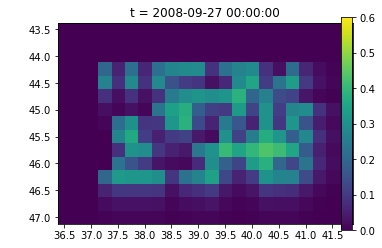

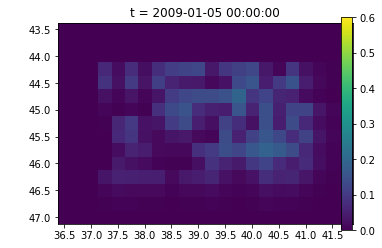

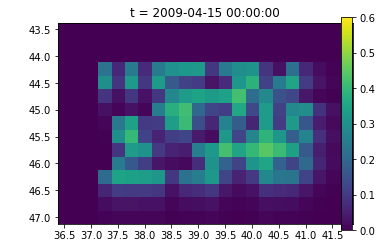

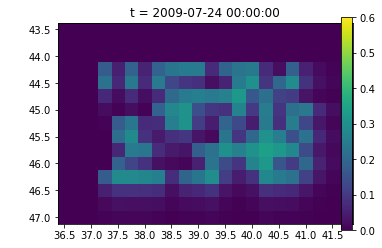

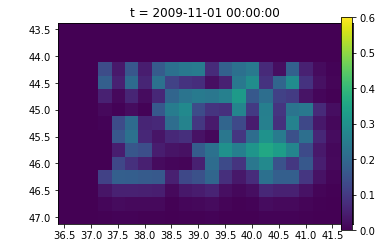

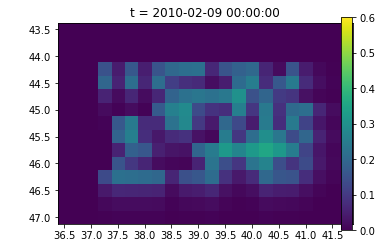

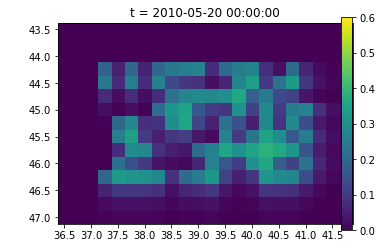

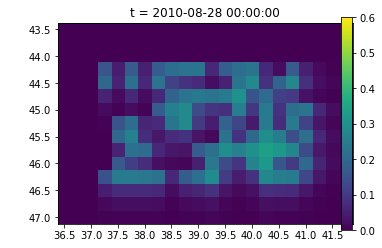

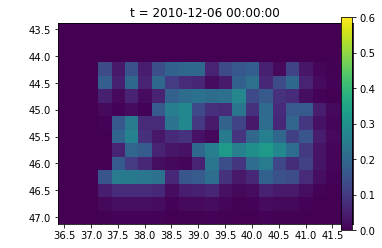

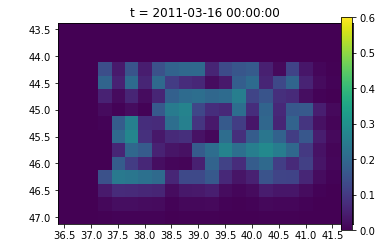

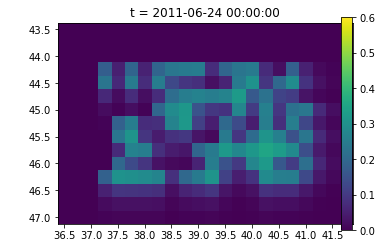

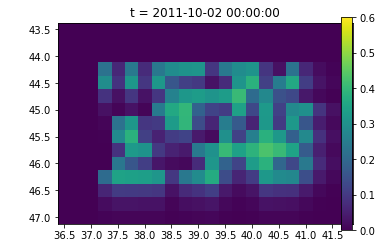

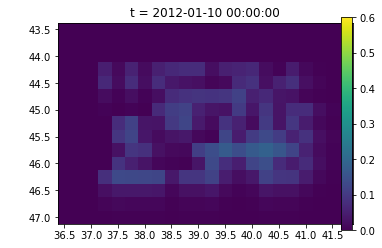

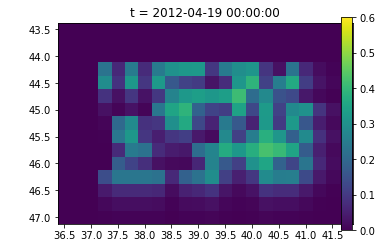

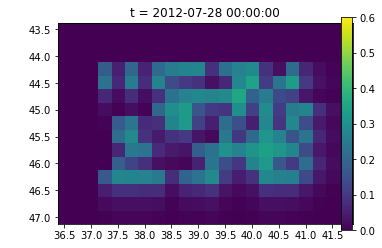

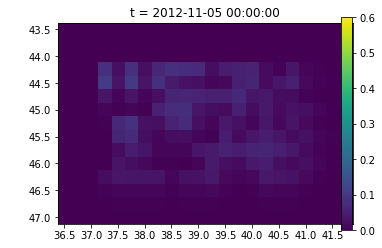

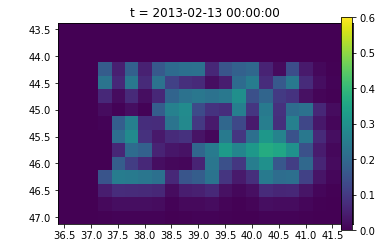

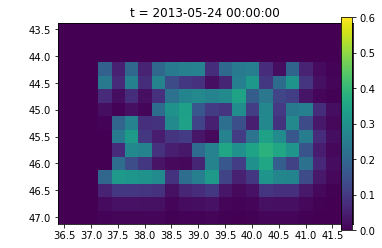

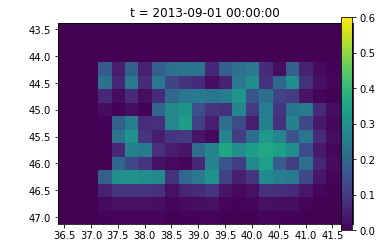

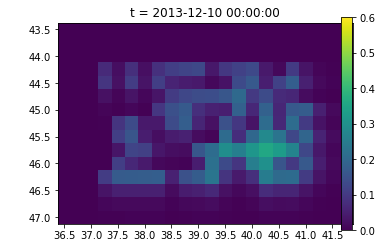

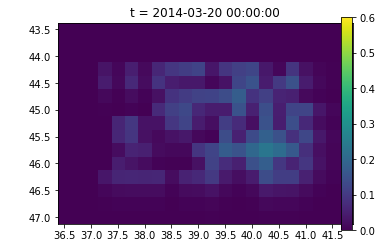

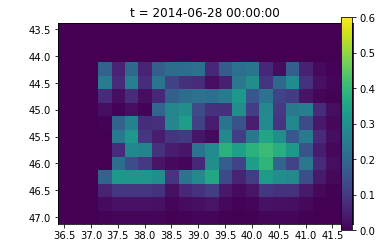

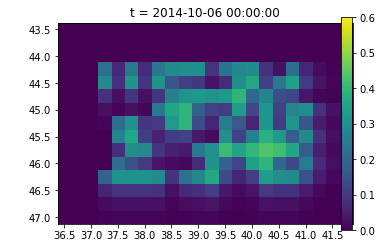

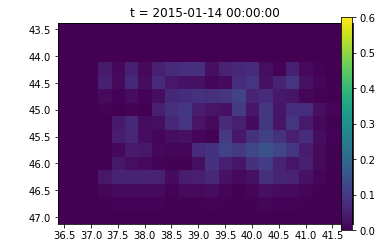

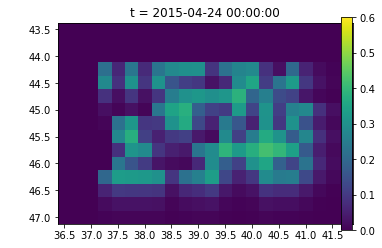

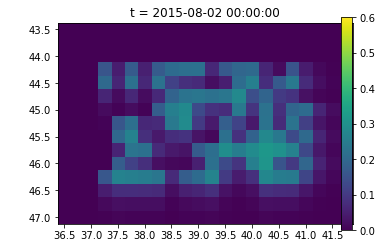

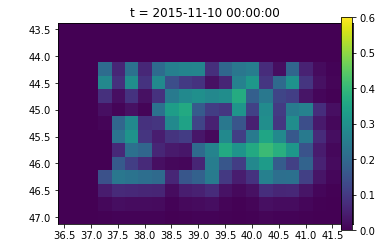

In [29]:
X = [36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5]
Y = [47.0, 46.5, 46.0, 45.5, 45.0, 44.5, 44.0, 43.5]

for t in list(range(grid_new.shape[0]))[::100]:
    data = grid_new[t, :, :]
    fig = plt.figure(figsize=(7, 3.7))

    ax = fig.add_subplot(111)
    ax.set_title('t = ' + str(start_date + pd.DateOffset(1) * t))
    plt.imshow(data,vmin=0, vmax=0.6)
    # plt.colorbar()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0,22,2), labels=X)
    ax.set_yticks(np.arange(14,-1,-2), labels=Y)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.savefig('tmp_dump/' + str(t) + '.png')
    # plt.show()

In [27]:
images = []
filenames = [os.path.join('tmp_dump', str(f) + '.png') for f in list(range(grid.shape[0]))[::100]]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('tmp_dump/wind_prob_maps.gif', images, duration=0.5)